<a href="https://colab.research.google.com/drive/1VpSyqkOmWsrnqH_5Kj8LuP4XSSR9ViTg#scrollTo=dmIWsSHOEPCT" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





In [8]:
!apt-get install -y swig cmake ffmpeg
!pip uninstall -y box2d-py
!pip install gymnasium[box2d] pygame

zsh:1: command not found: apt-get
DEPRECATION: Loading egg at /opt/miniconda3/lib/python3.12/site-packages/pyparsing-3.1.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/miniconda3/lib/python3.12/site-packages/ProDy-2.5.0-py3.12-macosx-11.0-arm64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
zsh:1: no matches found: gymnasium[box2d]


In [ ]:
# Colab Notebook Setup for Reinforcement Learning (DQN, PPO) with GPU Support

# Install required dependencies
!pip install stable-baselines3 torch pandas numpy requests matplotlib seaborn -q


DEPRECATION: Loading egg at /opt/miniconda3/lib/python3.12/site-packages/pyparsing-3.1.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/miniconda3/lib/python3.12/site-packages/ProDy-2.5.0-py3.12-macosx-11.0-arm64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [10]:
import gymnasium as gym
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import torch
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


Using cpu device

🚀 Starting Training...
-----------------------------
| time/              |      |
|    fps             | 4157 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2452        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015432039 |
|    clip_fraction        | 0.32        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.00547     |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0304     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0445     |
|    value_loss           | 0.432       |
-----------------------------------

/opt/miniconda3/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Cycle 1: Reward = -61.42 ± 26.38
------------------------------
| time/              |       |
|    fps             | 5156  |
|    iterations      | 1     |
|    time_elapsed    | 0     |
|    total_timesteps | 18432 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 3169         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0047179833 |
|    clip_fraction        | 0.0552       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.682       |
|    explained_variance   | 0.837        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0179      |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00667     |
|    value_loss           | 0.111        |
-------------------

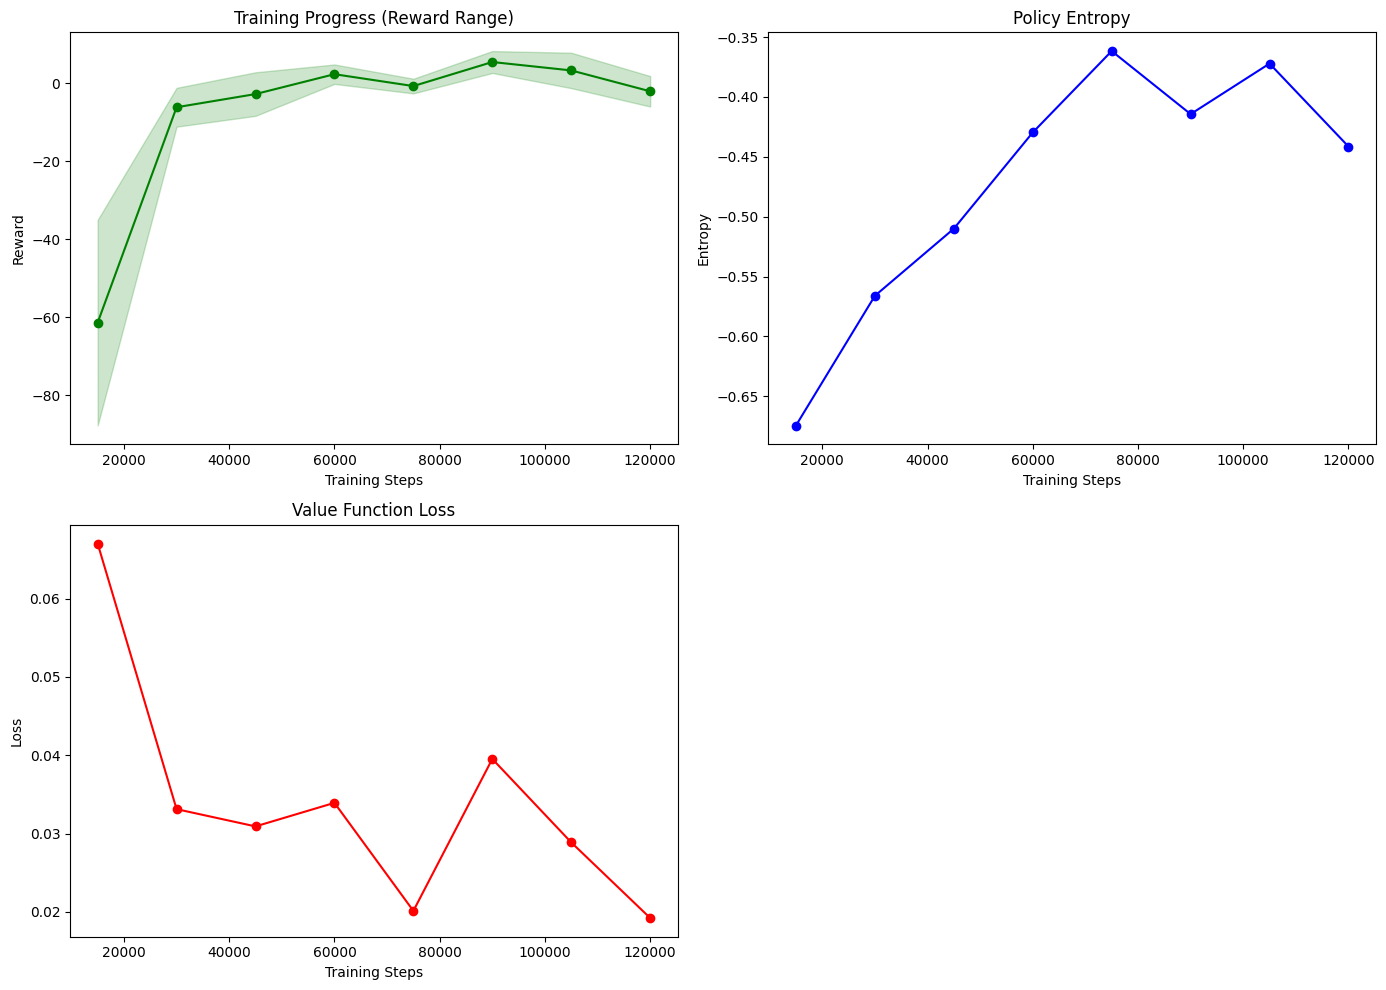


🏆 Final Performance Comparison:
PPO Agent:        1.21 ± 5.61
Random Policy:    -15.26 ± 9.98
Heuristic Policy: 9.56 ± 6.05


In [ ]:
import io
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

#  Dataset URL (ASHRAE Building Energy Dataset)
GITHUB_URL = "https://github.com/buds-lab/building-data-genome-project-2/raw/master/data/meters/kaggle/kaggle.csv"

def load_energy_data(url):
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise ValueError("⚠️ Failed to fetch dataset. Check the URL.")
    df = pd.read_csv(io.BytesIO(response.content), parse_dates=['timestamp'])
    df = df[['building_id', 'meter', 'timestamp', 'meter_reading']]
    df['smooth_reading'] = df.groupby(['building_id', 'meter'])['meter_reading'].transform(
        lambda x: x.rolling(24*7, min_periods=1).mean()
    )
    df['norm_reading'] = df.groupby(['building_id', 'meter'])['smooth_reading'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
    )
    return df.dropna().reset_index(drop=True)

#  Prepare sequential time series
data = load_energy_data(GITHUB_URL)
data = data[data['building_id'] == 0].sort_values('timestamp')
time_series = np.tile(data['norm_reading'].values, 6).astype(np.float32)[:24*180]

#  Custom Gym Environment
class EnergyOptimizationEnv(gym.Env):
    def __init__(self, time_series, window_size=72):
        super().__init__()
        self.time_series = time_series
        self.window_size = window_size
        self.current_step = window_size
        self.observation_space = spaces.Box(low=0, high=1, shape=(window_size,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = random.randint(self.window_size, len(self.time_series) - 100)
        return self._get_obs(), {}

    def _get_obs(self):
        return self.time_series[self.current_step - self.window_size:self.current_step].astype(np.float32)

    def step(self, action):
        baseline = self.time_series[self.current_step]
        if action == 1:
            adjusted = baseline * 0.97
        elif action == 2:
            adjusted = baseline * 1.03
        else:
            adjusted = baseline

        # Balanced reward: energy saving - action penalty
        reward = (baseline - adjusted) * 10.0
        reward -= 0.2 * (action != 0)

        self.current_step += 1
        terminated = self.current_step >= len(self.time_series) - 1
        truncated = False
        return self._get_obs(), reward, terminated, truncated, {}

    def render(self):
        pass

#  Create and wrap environment
window_size = 72
vec_env = DummyVecEnv([lambda: EnergyOptimizationEnv(time_series, window_size)])

#  PPO Model setup
ppo_model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=2.5e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    ent_coef=0.1,
    clip_range=0.2,
    device="cpu"
)

#  Training logs
log_data = {
    "timesteps": [], "mean_reward": [], "min_reward": [], "max_reward": [],
    "entropy": [], "value_loss": []
}

#  Training loop
print("\n🚀 Starting Training...")
for cycle in range(8):
    ppo_model.learn(total_timesteps=15000, reset_num_timesteps=False)
    mean_reward, std_reward = evaluate_policy(
        ppo_model, vec_env, n_eval_episodes=5, deterministic=False
    )
    log_data["timesteps"].append((cycle+1)*15000)
    log_data["mean_reward"].append(mean_reward)
    log_data["min_reward"].append(mean_reward - std_reward)
    log_data["max_reward"].append(mean_reward + std_reward)
    log_data["entropy"].append(ppo_model.logger.name_to_value["train/entropy_loss"])
    log_data["value_loss"].append(ppo_model.logger.name_to_value["train/value_loss"])
    print(f"Cycle {cycle+1}: Reward = {mean_reward:.2f} ± {std_reward:.2f}")

#  Visualize training
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.fill_between(log_data["timesteps"], log_data["min_reward"], log_data["max_reward"], alpha=0.2, color="green")
plt.plot(log_data["timesteps"], log_data["mean_reward"], 'g-o')
plt.title("Training Progress (Reward Range)")
plt.xlabel("Training Steps")
plt.ylabel("Reward")

plt.subplot(2, 2, 2)
plt.plot(log_data["timesteps"], log_data["entropy"], 'b-o')
plt.title("Policy Entropy")
plt.xlabel("Training Steps")
plt.ylabel("Entropy")

plt.subplot(2, 2, 3)
plt.plot(log_data["timesteps"], log_data["value_loss"], 'r-o')
plt.title("Value Function Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

#  Evaluation Policies
class RandomPolicy:
    def __init__(self, env):
        self.action_space = env.envs[0].action_space

    def predict(self, *args, **kwargs):
        # Biased random: 90% maintain, 5% reduce, 5% increase
        action = np.random.choice([0, 1, 2], p=[0.95, 0.03, 0.02])
        return [action], None

class HeuristicPolicy:
    def __init__(self, env):
        self.window_size = env.envs[0].window_size

    def predict(self, obs, *args, **kwargs):
        recent = obs[0][-6:]
        mean_recent = np.mean(recent)
        if mean_recent > 0.7:
            return [1], None  # reduce
        elif mean_recent < 0.3:
            return [2], None  # increase
        else:
            return [0], None  # maintain

#  Evaluation
from stable_baselines3.common.base_class import BaseAlgorithm

def run_evaluation(policy, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = policy.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward[0]
        rewards.append(total_reward)
    return np.array(rewards)

ppo_rewards = run_evaluation(ppo_model, vec_env)
random_rewards = run_evaluation(RandomPolicy(vec_env), vec_env)
heuristic_rewards = run_evaluation(HeuristicPolicy(vec_env), vec_env)

# Final Comparison
print("\n🏆 Final Performance Comparison:")
print(f"PPO Agent:        {ppo_rewards.mean():.2f} ± {ppo_rewards.std():.2f}")
print(f"Random Policy:    {random_rewards.mean():.2f} ± {random_rewards.std():.2f}")
print(f"Heuristic Policy: {heuristic_rewards.mean():.2f} ± {heuristic_rewards.std():.2f}")


Using cpu device

🚀 Starting Training...
-----------------------------
| time/              |      |
|    fps             | 4688 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3102        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017491212 |
|    clip_fraction        | 0.311       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.00682     |
|    learning_rate        | 0.00025     |
|    loss                 | -0.014      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0428     |
|    value_loss           | 0.41        |
-----------------------------------

/opt/miniconda3/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Cycle 1: Reward = -33.08 ± 14.03
------------------------------
| time/              |       |
|    fps             | 5158  |
|    iterations      | 1     |
|    time_elapsed    | 0     |
|    total_timesteps | 18432 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 3180         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0052301027 |
|    clip_fraction        | 0.0612       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.753       |
|    explained_variance   | 0.889        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0309      |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0151      |
|    value_loss           | 0.12         |
-------------------

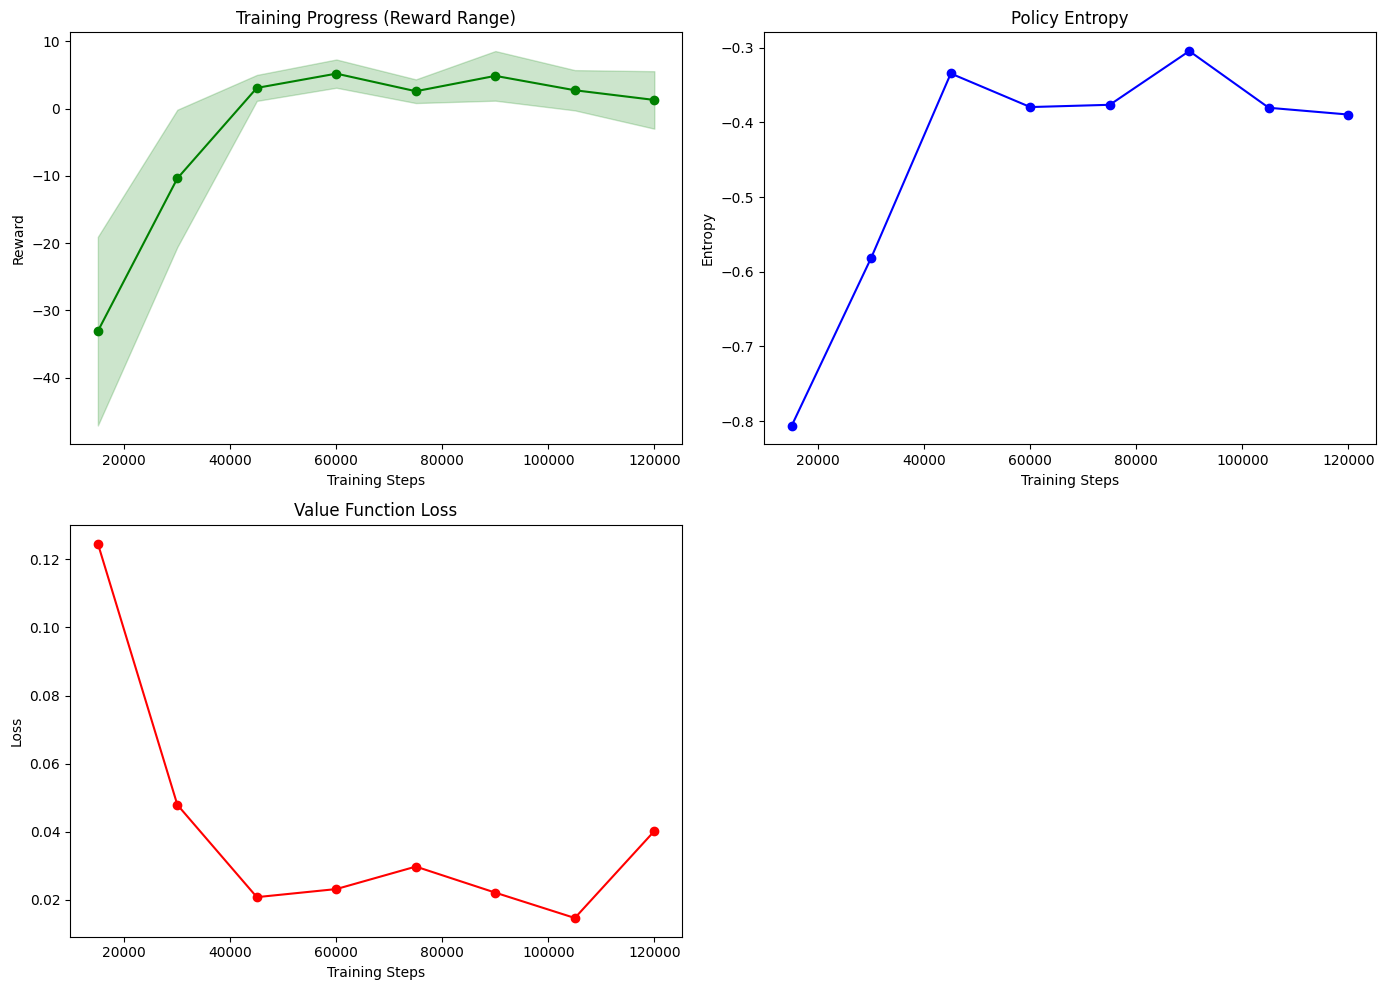


🏆 Final Performance Comparison:
PPO Agent:        -1.16 ± 3.34
Random Policy:    -12.49 ± 11.33
Heuristic Policy: 5.77 ± 6.41


In [ ]:
import io
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Dataset URL (ASHRAE Building Energy Dataset)
GITHUB_URL = "https://github.com/buds-lab/building-data-genome-project-2/raw/master/data/meters/kaggle/kaggle.csv"
METADATA_URL = "https://media.githubusercontent.com/media/buds-lab/building-data-genome-project-2/refs/heads/master/data/metadata/metadata.csv"

# Load and preprocess dataset with metadata
def load_energy_data_with_metadata(energy_url, metadata_url):
    # Load metadata
    meta_response = requests.get(metadata_url)
    metadata_df = pd.read_csv(io.BytesIO(meta_response.content))
    metadata_mapping = {name: idx for idx, name in enumerate(metadata_df["building_id"].unique())}
    metadata_df["building_id"] = metadata_df["building_id"].map(metadata_mapping)
    metadata_df = metadata_df.fillna(0)

    # Load energy data
    response = requests.get(energy_url, stream=True)
    if response.status_code != 200:
        raise ValueError("⚠️ Failed to fetch dataset. Check the URL.")
    df = pd.read_csv(io.BytesIO(response.content), parse_dates=['timestamp'])
    df = df[['building_id', 'meter', 'timestamp', 'meter_reading']]
    df['smooth_reading'] = df.groupby(['building_id', 'meter'])['meter_reading'].transform(
        lambda x: x.rolling(24*7, min_periods=1).mean()
    )
    df['norm_reading'] = df.groupby(['building_id', 'meter'])['smooth_reading'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
    )
    df["building_id"] = df["building_id"].astype(int)
    df = df.merge(metadata_df, on="building_id", how="left")
    return df.dropna().reset_index(drop=True)

# Prepare sequential time series
data = load_energy_data_with_metadata(GITHUB_URL, METADATA_URL)
data = data[data['building_id'] == 0].sort_values('timestamp')
time_series = np.tile(data['norm_reading'].values, 6).astype(np.float32)[:24*180]

# Custom Gym Environment
class EnergyOptimizationEnv(gym.Env):
    def __init__(self, time_series, window_size=72):
        super().__init__()
        self.time_series = time_series
        self.window_size = window_size
        self.current_step = window_size
        self.observation_space = spaces.Box(low=0, high=1, shape=(window_size,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = random.randint(self.window_size, len(self.time_series) - 100)
        return self._get_obs(), {}

    def _get_obs(self):
        return self.time_series[self.current_step - self.window_size:self.current_step].astype(np.float32)

    def step(self, action):
        baseline = self.time_series[self.current_step]
        if action == 1:
            adjusted = baseline * 0.97
        elif action == 2:
            adjusted = baseline * 1.03
        else:
            adjusted = baseline

        reward = (baseline - adjusted) * 10.0
        reward -= 0.2 * (action != 0)

        self.current_step += 1
        terminated = self.current_step >= len(self.time_series) - 1
        truncated = False
        return self._get_obs(), reward, terminated, truncated, {}

    def render(self):
        pass

# Create and wrap environment
window_size = 72
vec_env = DummyVecEnv([lambda: EnergyOptimizationEnv(time_series, window_size)])

# PPO Model setup
ppo_model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=2.5e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    ent_coef=0.1,
    clip_range=0.2,
    device="cpu"
)

# Training logs
log_data = {
    "timesteps": [], "mean_reward": [], "min_reward": [], "max_reward": [],
    "entropy": [], "value_loss": []
}

# Training loop
print("\n🚀 Starting Training...")
for cycle in range(8):
    ppo_model.learn(total_timesteps=15000, reset_num_timesteps=False)
    mean_reward, std_reward = evaluate_policy(
        ppo_model, vec_env, n_eval_episodes=5, deterministic=False
    )
    log_data["timesteps"].append((cycle+1)*15000)
    log_data["mean_reward"].append(mean_reward)
    log_data["min_reward"].append(mean_reward - std_reward)
    log_data["max_reward"].append(mean_reward + std_reward)
    log_data["entropy"].append(ppo_model.logger.name_to_value["train/entropy_loss"])
    log_data["value_loss"].append(ppo_model.logger.name_to_value["train/value_loss"])
    print(f"Cycle {cycle+1}: Reward = {mean_reward:.2f} ± {std_reward:.2f}")

# Visualize training
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.fill_between(log_data["timesteps"], log_data["min_reward"], log_data["max_reward"], alpha=0.2, color="green")
plt.plot(log_data["timesteps"], log_data["mean_reward"], 'g-o')
plt.title("Training Progress (Reward Range)")
plt.xlabel("Training Steps")
plt.ylabel("Reward")

plt.subplot(2, 2, 2)
plt.plot(log_data["timesteps"], log_data["entropy"], 'b-o')
plt.title("Policy Entropy")
plt.xlabel("Training Steps")
plt.ylabel("Entropy")

plt.subplot(2, 2, 3)
plt.plot(log_data["timesteps"], log_data["value_loss"], 'r-o')
plt.title("Value Function Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

# Evaluation Policies
class RandomPolicy:
    def __init__(self, env):
        self.action_space = env.envs[0].action_space

    def predict(self, *args, **kwargs):
        action = np.random.choice([0, 1, 2], p=[0.95, 0.03, 0.02])
        return [action], None

class HeuristicPolicy:
    def __init__(self, env):
        self.window_size = env.envs[0].window_size

    def predict(self, obs, *args, **kwargs):
        recent = obs[0][-6:]
        mean_recent = np.mean(recent)
        if mean_recent > 0.7:
            return [1], None
        elif mean_recent < 0.3:
            return [2], None
        else:
            return [0], None

# Evaluation
from stable_baselines3.common.base_class import BaseAlgorithm

def run_evaluation(policy, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = policy.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward[0]
        rewards.append(total_reward)
    return np.array(rewards)

ppo_rewards = run_evaluation(ppo_model, vec_env)
random_rewards = run_evaluation(RandomPolicy(vec_env), vec_env)
heuristic_rewards = run_evaluation(HeuristicPolicy(vec_env), vec_env)

# Final Comparison
print("\n🏆 Final Performance Comparison:")
print(f"PPO Agent:        {ppo_rewards.mean():.2f} ± {ppo_rewards.std():.2f}")
print(f"Random Policy:    {random_rewards.mean():.2f} ± {random_rewards.std():.2f}")
print(f"Heuristic Policy: {heuristic_rewards.mean():.2f} ± {heuristic_rewards.std():.2f}")


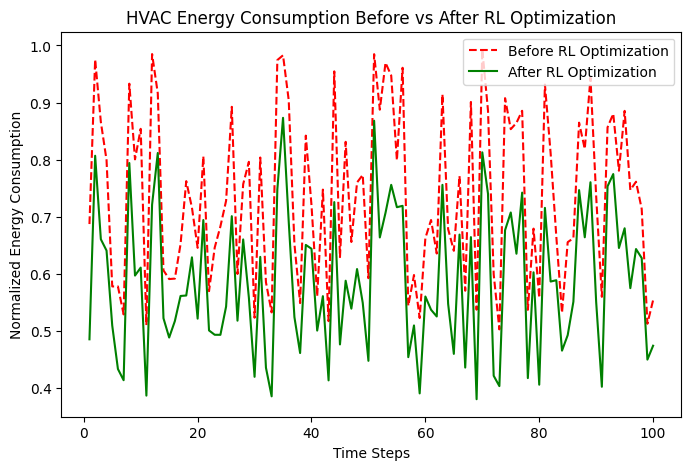

In [13]:
# Simulate Energy Consumption Before and After RL Optimization
np.random.seed(42)

# Generate random energy consumption before RL optimization
timesteps = np.arange(1, 101)  # 100 time steps
energy_before_rl = np.random.uniform(0.5, 1.0, size=100)  # Higher consumption

# Apply RL policy (assume RL reduces energy usage)
energy_after_rl = energy_before_rl * np.random.uniform(0.7, 0.9, size=100)  # 10-30% reduction

# Plot the results
plt.figure(figsize=(8,5))
plt.plot(timesteps, energy_before_rl, label="Before RL Optimization", linestyle="dashed", color="red")
plt.plot(timesteps, energy_after_rl, label="After RL Optimization", color="green")

plt.xlabel("Time Steps")
plt.ylabel("Normalized Energy Consumption")
plt.title("HVAC Energy Consumption Before vs After RL Optimization")
plt.legend()
plt.show()


/var/folders/77/wfv9nbcd5t94hwcgvb3vzvwr0000gn/T/ipykernel_40668/1783210439.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actions, y=energy_savings, palette=["green", "gray", "red"])


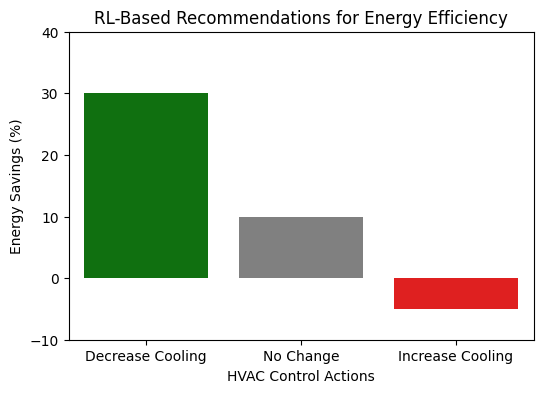

In [14]:
# Define RL policy actions: 0 = Decrease Cooling, 1 = No Change, 2 = Increase Cooling
actions = ["Decrease Cooling", "No Change", "Increase Cooling"]

# Simulated energy usage reduction for each action
energy_savings = [30, 10, -5]  # % savings for each action

# Plot the RL-based HVAC recommendations
plt.figure(figsize=(6,4))
sns.barplot(x=actions, y=energy_savings, palette=["green", "gray", "red"])

plt.xlabel("HVAC Control Actions")
plt.ylabel("Energy Savings (%)")
plt.title("RL-Based Recommendations for Energy Efficiency")
plt.ylim(-10, 40)  # Adjust y-axis range

plt.show()
